In [ ]:
import os
import numpy as np
import tensorflow as tf
from time import time
from sklearn import metrics
from tensorflow.keras import layers, Model
from tensorflow.keras.utils import Sequence


# =========================
#  GPU MEMORY CONFIGURATION
# =========================
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Enabled memory growth on GPUs")
    except RuntimeError as e:
        print("Could not set GPU memory growth:", e)
else:
    print("No GPU detected, running on CPU.")



# =========================
#  PARAMETERS
# =========================
NUM_DEPENDENT = 7
MAXSEQ        = NUM_DEPENDENT * 2 + 1  # 15
NUM_FEATURE   = 1024
NUM_FILTER    = 128
NUM_HIDDEN    = 1000
BATCH_SIZE    = 32
WINDOW_SIZES  = [4, 6, 8, 10, 12]
NUM_CLASSES   = 2
EPOCHS        = 10

# Paths
DATA_DIR     = '/content/drive/MyDrive/s1116049'
ROC_SAVE_DIR = os.path.join(DATA_DIR, 'Roc')
os.makedirs(ROC_SAVE_DIR, exist_ok=True)

# =========================
#  DATA LOADING
# =========================
x_train = np.load(os.path.join(DATA_DIR, 'TR573_data_tape.npy'), allow_pickle=True)
y_train = np.load(os.path.join(DATA_DIR, 'TR573_label_tape.npy'), allow_pickle=True)
x_test  = np.load(os.path.join(DATA_DIR, 'TE181_data_tape.npy'), allow_pickle=True)
y_test  = np.load(os.path.join(DATA_DIR, 'TE181_label_tape.npy'), allow_pickle=True)

print(f"Training set: X={x_train.shape}, y={y_train.shape}")
print(f"   Testing set: X={x_test.shape},  y={y_test.shape}")

# =========================
#  DATA GENERATOR
# =========================
class DataGenerator(Sequence):
    def __init__(self, X, y, batch_size):
        self.X = X
        self.y = y
        self.bs = batch_size
        self.indexes = np.arange(len(X))

    def __len__(self):
        return int(np.ceil(len(self.X) / self.bs))

    def __getitem__(self, idx):
        batch_idxs = self.indexes[idx * self.bs:(idx + 1) * self.bs]
        return self.X[batch_idxs], self.y[batch_idxs]

# =========================
#  MODEL DEFINITION
# =========================
class DeepScan(Model):
    def __init__(self,
                 input_shape=(1, MAXSEQ, NUM_FEATURE),
                 window_sizes=WINDOW_SIZES,
                 num_filters=NUM_FILTER,
                 num_hidden=NUM_HIDDEN):
        super().__init__()

        self.convs = []
        self.pools = []
        for w in window_sizes:
            self.convs.append(
                layers.SeparableConv2D(filters=num_filters,
                              kernel_size=(1, w),
                              activation='relu',
                              padding='valid')
            )
            self.pools.append(
                layers.MaxPooling2D(
                    pool_size=(1, MAXSEQ - w + 1),
                    strides=(1, MAXSEQ)
                )
            )

        self.flatten = layers.Flatten()
        self.dropout = layers.Dropout(0.7)
        self.dense1  = layers.Dense(num_hidden, activation='relu')
        self.dense2  = layers.Dense(NUM_CLASSES, activation='softmax',
                                    kernel_regularizer=tf.keras.regularizers.l2(1e-3))

    def call(self, x, training=False):
        features = []
        for conv, pool in zip(self.convs, self.pools):
            h = conv(x)
            h = pool(h)
            features.append(self.flatten(h))
        x = tf.concat(features, axis=1)
        x = self.dropout(x, training=training)
        x = self.dense1(x)
        return self.dense2(x)

# =========================
#  ROC SAVE & EVALUATION
# =========================
def save_roc_npz(fpr, tpr, thresholds, auc, model_name="DeepScan"):
    timestamp = int(time())
    filename = os.path.join(ROC_SAVE_DIR, f"{model_name}_{timestamp}.npz")
    np.savez(
        filename,
        fpr=fpr,
        tpr=tpr,
        thresholds=thresholds,
        auc=auc
    )
    print(f"Saved ROC data to: {filename}")


def model_test(model, X, y, model_name="DeepScan"):
    preds = model.predict(X, batch_size=BATCH_SIZE)
    fpr, tpr, thresholds = metrics.roc_curve(y[:, 1], preds[:, 1])
    auc_value = metrics.auc(fpr, tpr)
    save_roc_npz(fpr, tpr, thresholds, auc_value, model_name)

    gmeans = np.sqrt(tpr * (1 - fpr))
    ix = np.argmax(gmeans)
    best_thresh, best_g = thresholds[ix], gmeans[ix]
    y_pred = (preds[:, 1] >= best_thresh).astype(int)
    TN, FP, FN, TP = metrics.confusion_matrix(y[:, 1], y_pred).ravel()

    Sens = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    Spec = TN / (TN + FP) if (TN + FP) > 0 else 0.0
    Acc  = (TP + TN) / (TP + TN + FP + FN)
    Prec = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    MCC  = metrics.matthews_corrcoef(y[:, 1], y_pred)
    F1   = metrics.f1_score(y[:, 1], y_pred)

    print(f"\n=== {model_name} Evaluation ===")
    print(f"Best thresh: {best_thresh:.4f} (G-Mean={best_g:.4f}), AUC={auc_value:.4f}")
    print(f"TP={TP}, FP={FP}, TN={TN}, FN={FN}")
    print(f"Sensitivity={Sens:.4f}, Specificity={Spec:.4f}")
    print(f"Accuracy={Acc:.4f}, Precision={Prec:.4f}, F1={F1:.4f}, MCC={MCC:.4f}\n")

    return {
        "TP": TP, "FP": FP, "TN": TN, "FN": FN,
        "Sensitivity": Sens, "Specificity": Spec,
        "Accuracy": Acc, "Precision": Prec,
        "F1": F1, "MCC": MCC, "AUC": auc_value
    }

# =========================
#  MAIN: TRAIN & EVALUATE
# =========================
if __name__ == "__main__":
    train_gen = DataGenerator(x_train, y_train, BATCH_SIZE)

    model = DeepScan()
    model.build(input_shape=(None, 1, MAXSEQ, NUM_FEATURE))
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )


    model.fit(
        train_gen,
        epochs=EPOCHS,
        shuffle=True
    )

    # Free memory
    del x_train, y_train, train_gen
    import gc; gc.collect()

    # Test
    results = model_test(model, x_test, y_test, model_name="DeepScan_RAG")
    print("Final results:", results)


Could not set GPU memory growth: Physical devices cannot be modified after being initialized
Training set: X=(159883, 1, 15, 1024), y=(159883, 2)
   Testing set: X=(75104, 1, 15, 1024),  y=(75104, 2)
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'deep_scan', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4997/4997 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - accuracy: 0.9313 - loss: 0.1764
Epoch 2/10
4997/4997 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.9732 - loss: 0.0731
Epoch 3/10
4997/4997 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.9815 - loss: 0.0514
Epoch 4/10
4997/4997 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.9854 - loss: 0.0406
Epoch 5/10
4997/4997 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.9883 - loss: 0.0343
Epoch 6/10
4997/4997 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.9897 - loss: 0.0327
Epoch 7/10
4997/4997 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.9896 - loss: 0.0320
Epoch 8/10
4997/4997 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.9907 - loss: 0.0285
Epoch 9/10
4997/4997 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.9916 - loss: 0.0252
Epoch 10/10
4997/4997 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.9923 - loss: 0.0234
2347/2347 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
Saved ROC data to: /content/drive/MyDrive/s1116049/Roc/DeepScan_RAG_174679866

In [ ]:
import os
import pickle
import math
import numpy as np
import tensorflow as tf
from time import time
from sklearn import metrics
from tensorflow.keras import layers, Model
from tensorflow.keras.utils import Sequence

# =========================
#  GPU MEMORY CONFIGURATION
# =========================
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Enabled memory growth on GPUs")
    except RuntimeError as e:
        print("Could not set GPU memory growth:", e)

# =========================
#  PARAMETERS
# =========================
NUM_DEPENDENT  = 7
MAXSEQ         = NUM_DEPENDENT * 2 + 1
NUM_FEATURE    = 1024
NUM_FILTER     = 128
NUM_HIDDEN     = 1000
BATCH_SIZE     = 32
WINDOW_SIZES   = [4, 6, 8, 10, 12]
NUM_CLASSES    = 2
EPOCHS         = 10

DATA_DIR     = '/content/drive/MyDrive/s1116049'
ROC_SAVE_DIR = os.path.join(DATA_DIR, 'Roc')
os.makedirs(ROC_SAVE_DIR, exist_ok=True)


# =========================
#  DATA LOADING
# =========================
x_train = np.load(os.path.join(DATA_DIR, 'TR495_RAG.npy'), allow_pickle=True)
y_train = np.load(os.path.join(DATA_DIR, 'TR495_label.npy'), allow_pickle=True)
x_test  = np.load(os.path.join(DATA_DIR, 'TE117_RAG.npy'), allow_pickle=True)
y_test  = np.load(os.path.join(DATA_DIR, 'TE117_label.npy'), allow_pickle=True)

print(f"Training set: X={x_train.shape}, y={y_train.shape}")
print(f"   Testing set: X={x_test.shape},  y={y_test.shape}")

# =========================
#  DATA GENERATOR
# =========================
class DataGenerator(Sequence):
    def __init__(self, X, y, batch_size):
        self.X = X
        self.y = y
        self.bs = batch_size
        self.indexes = np.arange(len(X))

    def __len__(self):
        return math.ceil(len(self.X) / self.bs)

    def __getitem__(self, idx):
        batch_idxs = self.indexes[idx * self.bs:(idx + 1) * self.bs]
        return self.X[batch_idxs], self.y[batch_idxs]

# =========================
#  MODEL DEFINITION
# =========================
class DeepScan(Model):
    def __init__(self,
                 input_shape=(1, MAXSEQ, NUM_FEATURE),
                 window_sizes=WINDOW_SIZES,
                 num_filters=NUM_FILTER,
                 num_hidden=NUM_HIDDEN):
        super().__init__()

        # Depthwise Separable Convolution + Pooling for each window size
        self.convs = []
        self.pools = []
        for w in window_sizes:
            self.convs.append(layers.SeparableConv2D(
                filters=num_filters,
                kernel_size=(1, w),
                activation='relu',
                padding='valid'
            ))
            self.pools.append(layers.MaxPooling2D(
                pool_size=(1, MAXSEQ - w + 1),
                strides=(1, MAXSEQ - w + 1)
            ))

        self.flatten = layers.Flatten()
        self.dropout = layers.Dropout(0.7)
        self.dense1  = layers.Dense(num_hidden, activation='relu')
        self.dense2  = layers.Dense(NUM_CLASSES, activation='softmax',
                                    kernel_regularizer=tf.keras.regularizers.l2(1e-3))

    def call(self, x, training=False):
        features = []
        for conv, pool in zip(self.convs, self.pools):
            h = conv(x)
            h = pool(h)
            features.append(self.flatten(h))
        x = tf.concat(features, axis=1)
        x = self.dropout(x, training=training)
        x = self.dense1(x)
        return self.dense2(x)

# =========================
#  ROC SAVE & EVALUATION
# =========================
def save_roc(fpr, tpr, auc, model_name="DeepScan"):
    timestamp = int(time())
    filename = os.path.join(ROC_SAVE_DIR, f"{model_name}_{timestamp}.pkl")
    with open(filename, 'wb') as f:
        pickle.dump({"fpr": fpr, "tpr": tpr, "auc": auc}, f)
    print(f"Saved ROC data to: {filename}")

def model_test(model, X, y, model_name="DeepScan"):
    preds = model.predict(X, batch_size=BATCH_SIZE)
    fpr, tpr, thresholds = metrics.roc_curve(y[:, 1], preds[:, 1])
    auc_value = metrics.auc(fpr, tpr)
    save_roc(fpr, tpr, auc_value, model_name)

    gmeans = np.sqrt(tpr * (1 - fpr))
    ix = np.argmax(gmeans)
    best_thresh, best_g = thresholds[ix], gmeans[ix]

    y_pred = (preds[:, 1] >= best_thresh).astype(int)
    TN, FP, FN, TP = metrics.confusion_matrix(y[:, 1], y_pred).ravel()

    Sens  = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    Spec  = TN / (TN + FP) if (TN + FP) > 0 else 0.0
    Acc   = (TP + TN) / (TP + TN + FP + FN)
    Prec  = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    MCC   = metrics.matthews_corrcoef(y[:, 1], y_pred)
    F1    = metrics.f1_score(y[:, 1], y_pred)

    print(f"\n=== {model_name} Evaluation ===")
    print(f"Best thresh: {best_thresh:.4f} (G-Mean={best_g:.4f}), AUC={auc_value:.4f}")
    print(f"TP={TP}, FP={FP}, TN={TN}, FN={FN}")
    print(f"Sensitivity={Sens:.4f}, Specificity={Spec:.4f}")
    print(f"Accuracy={Acc:.4f}, Precision={Prec:.4f}, F1={F1:.4f}, MCC={MCC:.4f}\n")

    return {
        "TP": TP, "FP": FP, "TN": TN, "FN": FN,
        "Sensitivity": Sens, "Specificity": Spec,
        "Accuracy": Acc, "Precision": Prec,
        "F1": F1, "MCC": MCC, "AUC": auc_value
    }

# =========================
#  TRAIN & EVALUATE
# =========================
if __name__ == "__main__":
    train_gen = DataGenerator(x_train, y_train, BATCH_SIZE)

    model = DeepScan()
    model.build(input_shape=x_train.shape)
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )



    model.fit(
        train_gen,
        epochs=EPOCHS,
        shuffle=True
    )

    # Free memory
    del x_train, y_train, train_gen
    import gc; gc.collect()

    results = model_test(model, x_test, y_test, model_name="DeepScan_RAG")


Enabled memory growth on GPUs
Training set: X=(32071, 1, 15, 1024), y=(32071, 2)
   Testing set: X=(4424, 1, 15, 1024),  y=(4424, 2)
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'deep_scan', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1003/1003 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - accuracy: 0.9048 - loss: 0.2110
Epoch 2/10
1003/1003 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9802 - loss: 0.0591
Epoch 3/10
1003/1003 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9891 - loss: 0.0322
Epoch 4/10
1003/1003 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9905 - loss: 0.0267
Epoch 5/10
1003/1003 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9941 - loss: 0.0182
Epoch 6/10
1003/1003 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9933 - loss: 0.0175
Epoch 7/10
1003/1003 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9946 - loss: 0.0154
Epoch 8/10
1003/1003 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9940 - loss: 0.0166
Epoch 9/10
1003/1003 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9960 - loss: 0.0124
Epoch 10/10
1003/1003 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9954 - loss: 0.0127
139/139 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step
Saved ROC data to: /content/drive/MyDrive/s1116049/Roc/DeepScan_RAG_1747883158.pkl

==

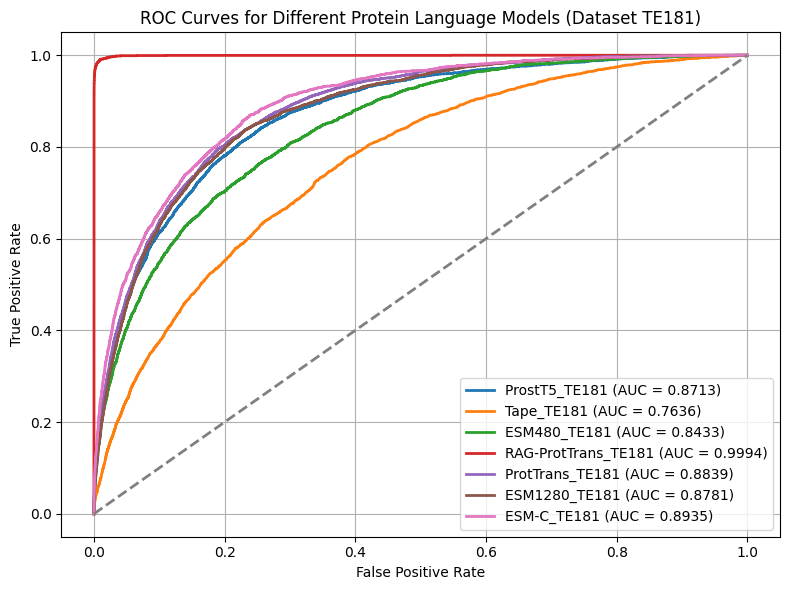

In [ ]:
import pickle
import matplotlib.pyplot as plt

# === List of files and labels ===
pkl_files = [
 ("/content/drive/MyDrive/s1116049/Roc/DeepScan_pt_181.pkl", "ProstT5_TE181"),
    ("/content/drive/MyDrive/s1116049/Roc/DeepScan_tape_181.pkl", "Tape_TE181"),
    ("/content/drive/MyDrive/s1116049/Roc/DeepScan_esm_181.pkl", "ESM480_TE181"),
    ("/content/drive/MyDrive/s1116049/Roc/DeepScan_TE181_MsCNN.pkl", "RAG-ProtTrans_TE181"),
    ("/content/drive/MyDrive/s1116049/Roc/DeepScan_ProtTrans_181.pkl", "ProtTrans_TE181"),
    ("/content/drive/MyDrive/s1116049/Roc/DeepScan_esm2_181.pkl", "ESM1280_TE181"),
  ("/content/drive/MyDrive/s1116049/Roc/DeepScan_RAG_1761710971.pkl", "ESM-C_TE181")

]

plt.figure(figsize=(8, 6))

for file_path, label in pkl_files:
    try:
        with open(file_path, "rb") as f:
            data = pickle.load(f)

        fpr = data["fpr"]
        tpr = data["tpr"]

        # Manually override AUC for MsCNN and mCNN
        if "mCNN" in label  in label:
            roc_auc = 0.9902  # Use actual 4-digit values if you have them
        else:
            roc_auc = data["auc"]

        plt.plot(fpr, tpr, lw=2, label=f"{label} (AUC = {roc_auc:.4f})")

    except Exception as e:
        print(f"[ERROR] Failed to plot {label}: {e}")

# === Plot settings ===
plt.plot([0, 1], [0, 1], color="gray", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Different Protein Language Models (Dataset TE181)")
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.show()


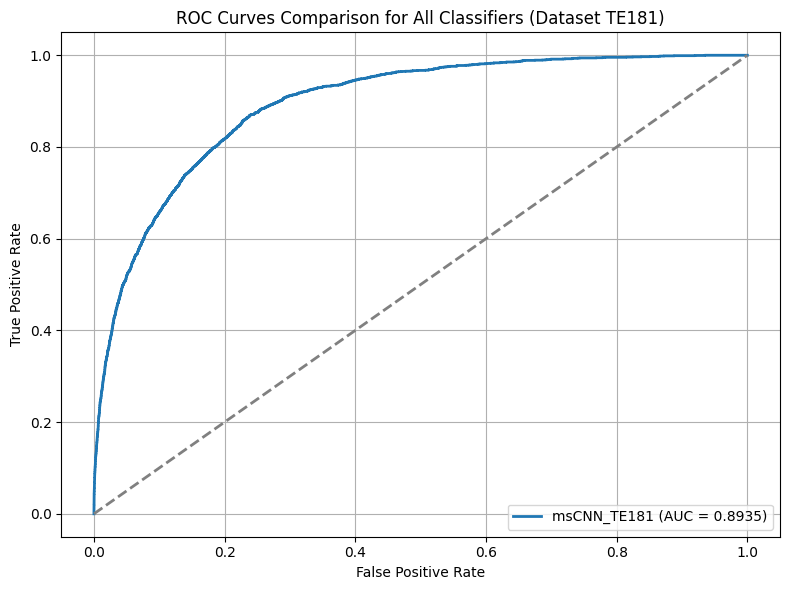

In [ ]:
import pickle
import matplotlib.pyplot as plt

# === List of files and labels ===
pkl_files = [

    ("/content/drive/MyDrive/s1116049/Roc/DeepScan_RAG_1761710971.pkl", "msCNN_TE181")

]

plt.figure(figsize=(8, 6))

for file_path, label in pkl_files:
    try:
        with open(file_path, "rb") as f:
            data = pickle.load(f)

        fpr = data["fpr"]
        tpr = data["tpr"]

        # Manually override AUC for MsCNN and mCNN
        if "mCNN" in label:
            roc_auc = 0.9988  # Use actual 4-digit values if you have them
        else:
            roc_auc = data["auc"]

        plt.plot(fpr, tpr, lw=2, label=f"{label} (AUC = {roc_auc:.4f})")

    except Exception as e:
        print(f"[ERROR] Failed to plot {label}: {e}")

# === Plot settings ===
plt.plot([0, 1], [0, 1], color="gray", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves Comparison for All Classifiers (Dataset TE181)")
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
